# Quality Metrics and Reconstruction Demo

Import tomography/xdesign and define a small progress bar function for our data collection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import adjust_gamma, rescale_intensity
from xdesign import *


def rescale(reconstruction, hi):
    I = rescale_intensity(reconstruction, out_range=(0., 1.))
    return adjust_gamma(I, 1, hi)

`polytope` failed to import `cvxopt.glpk`.
Will use `scipy.optimize.linprog`.


Generate a phantom similiar to soil.

/home/beams0/B242827/Documents/xdesign/xdesign/phantom.py:226: RuntimeWarning: Reached termination criteria of 200 attempts before adding all of the circles.
  "all of the circles.", RuntimeWarning)


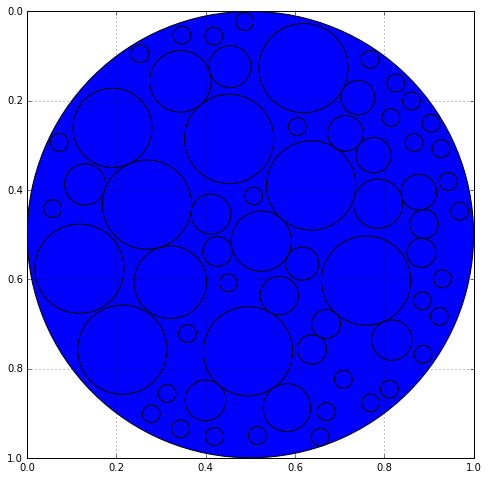

In [3]:
np.random.seed(0)
soil_like_phantom = Soil()

plot_phantom(soil_like_phantom)
plt.show()

Simulate data acquisition for parallel beam around 180 degrees.

[##########] 100.00%


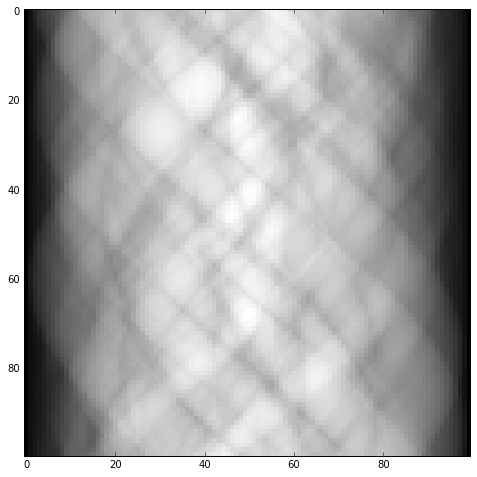

In [3]:
sx, sy = 100, 100
step = 1. / sy
prb = Probe(Point(step / 2., -10), Point(step / 2., 10), step)
theta = np.pi / sx
sino = np.zeros(sx * sy)
a = 0
for m in range(sx):
    for n in range(sy):
        update_progress((m*sy + n)/(sx*sy))
        sino[a] = prb.measure(soil_like_phantom)
        a += 1
        prb.translate(step)
    prb.translate(-1)
    prb.rotate(theta, Point(0.5, 0.5))
update_progress(1)

plt.figure(figsize=(8, 8))
plt.imshow(np.reshape(sino, (sx, sy)), cmap='gray', interpolation='nearest')
plt.show(block=True)

Reconstruct the phantom using 3 different techniques.

[##########] 100.00%
[##########] 100.00%
[##########] 100.00%


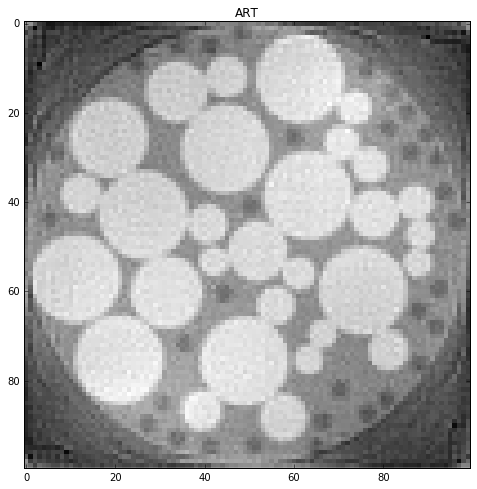

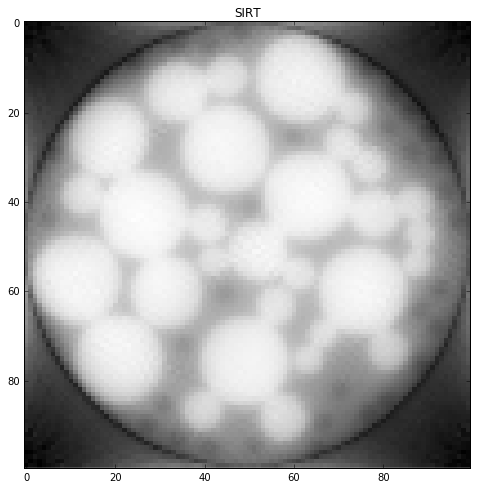

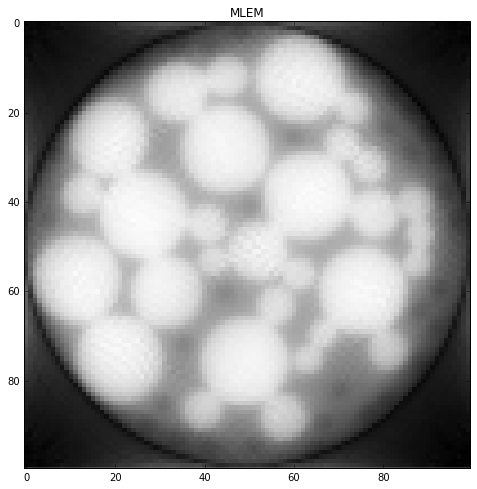

In [4]:
hi = 1  # highest expected value in reconstruction (for rescaling)
niter = 10  # number of iterations

init = 1e-12 * np.ones((sx, sy))
rec_art = art(prb, sino, init, niter)
rec_art = rescale(np.rot90(rec_art)[::-1], hi)
plt.figure(figsize=(8, 8))
plt.imshow(rec_art, cmap='gray', interpolation='none')
plt.title('ART')

init = 1e-12 * np.ones((sx, sy))
rec_sirt = sirt(prb, sino, init, niter)
rec_sirt = rescale(np.rot90(rec_sirt)[::-1], hi)
plt.figure(figsize=(8, 8))
plt.imshow(rec_sirt, cmap='gray', interpolation='none')
plt.title('SIRT')

init = 1e-12 * np.ones((sx, sy))
rec_mlem = mlem(prb, sino, init, niter)
rec_mlem = rescale(np.rot90(rec_mlem)[::-1], hi)
plt.figure(figsize=(8, 8))
plt.imshow(rec_mlem, cmap='gray', interpolation='none')
plt.title('MLEM')

plt.show(block=True)

Generate a discrete version of the phantom of the same size as the reconstructions.

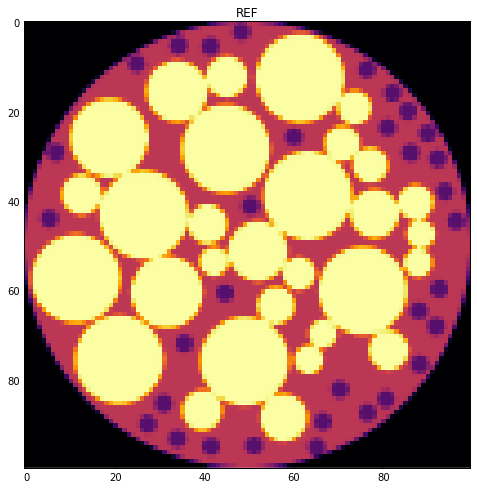

In [4]:
ref = discrete_phantom(soil_like_phantom, 100)
plt.figure(figsize=(8, 8))
plt.imshow(ref, cmap='inferno', interpolation='none')
plt.title('REF')

plt.show(block=True)

Compute quality metrics using the MSSSIM method.

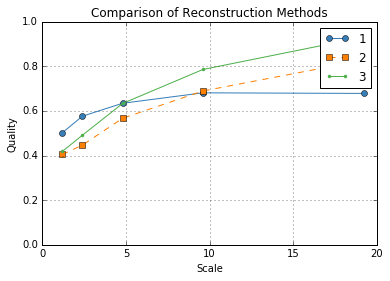

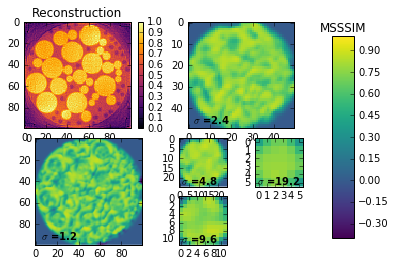

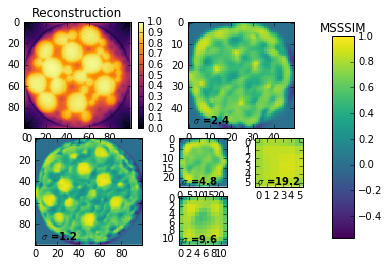

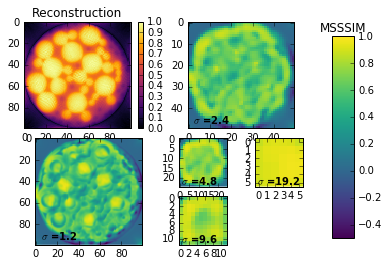

In [6]:
metrics = compute_quality(ref, [rec_art, rec_sirt, rec_mlem], method="MSSSIM")
plot_metrics(metrics)
plt.show(block=True)